<a href="https://colab.research.google.com/github/mattu117117/POS/blob/main/Lecture4_toyohashi_weather_relationships.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第4回 演習ノート：豊橋の気温・降水量・日照時間の関係を探る（時系列回帰）

**目的**
- 時系列データ（1時間）の読み込み・前処理を行う
- 気温（`temp_C`）と降水量（`precip_mm`）、日照時間（`sunshine_h`）の関係を可視化・定量化する
- 回帰分析（単回帰・重回帰）で影響度を推定する
- 季節ダミーとトレンドを加味してモデルを拡張する

**使用データ**
- `toyohashi_weather_with_season_dummies.csv`  
  - 列：`temp_C`（℃）、`precip_mm`（mm）、`sunshine_h`（h）、`season_spring`/`season_summer`/`season_autumn`/`season_winter`（0/1）
  - インデックス：`Datetime`（1時間間隔）

**課題について**
- Google ドキュメントで　ex4_B123456 というファイルを作る。
- 1行目は統計解析演習第4回演習、2行目は学籍番号　氏名　とする。
- それ以降に、このノートに記載された TODO への解答を記載する。
- ファイルは最終的にPDFファイルにして提出してください。

---

> 注：グラフは **matplotlib** を使用します（スタイルや色は適宜修正してください）。


In [ ]:
# ライブラリのインポート（必要ならインストール）
try:
    import statsmodels.api as sm
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "statsmodels"])
    import statsmodels.api as sm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Google drive のマウント
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## 1) データの読み込みと基本確認

- まず CSV を読み込み、期間や欠損の有無を確認します。
- `parse_dates=["Datetime"]` として時刻列を Datetime 型に変換し、インデックスに設定します。


In [ ]:
os.chdir(f'/content/drive/MyDrive/25StatisticalAnalysisEx./Lecture4')   # ←自分の環境に合うように適宜修正してください。
CSV_PATH = "data/toyohashi_weather_hourly_imputed.csv"

# もし上記パスで見つからない場合は、ファイルアップロードを促す
import os
if not os.path.exists(CSV_PATH):
    try:
        from google.colab import files
        print("ローカルからCSVをアップロードしてください")
        uploaded = files.upload()
        CSV_PATH = list(uploaded.keys())[0]
    except Exception as e:
        print("Colab外の場合は、適切なパスに置き換えてください:", e)

# 読み込み
df = pd.read_csv(CSV_PATH, parse_dates=["Datetime"], index_col="Datetime")
print("shape:", df.shape)
display(df.head())
display(df.info())


ローカルからCSVをアップロードしてください


Saving toyohashi_weather_hourly_imputed.csv to toyohashi_weather_hourly_imputed (2).csv
shape: (26328, 13)


,temp_C,precip_mm,sunshine_h,season_spring,season_summer,season_autumn,season_winter,temp_C_was_na,precip_mm_was_na,sunshine_h_was_na,temp_C_imputed,precip_mm_imputed,sunshine_h_imputed
Datetime,,,,,,,,,,,,,
2022-10-01 01:00:00,20.4,0.0,0.0,0,0,1,0,0,0,1,0,0,1
2022-10-01 02:00:00,20.3,0.0,0.0,0,0,1,0,0,0,1,0,0,1
2022-10-01 03:00:00,19.5,0.0,0.0,0,0,1,0,0,0,1,0,0,1
2022-10-01 04:00:00,19.4,0.0,0.0,0,0,1,0,0,0,1,0,0,1
2022-10-01 05:00:00,18.9,0.0,0.0,0,0,1,0,0,0,1,0,0,1


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26328 entries, 2022-10-01 01:00:00 to 2025-10-02 00:00:00
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temp_C              26328 non-null  float64
 1   precip_mm           26328 non-null  float64
 2   sunshine_h          26328 non-null  float64
 3   season_spring       26328 non-null  int64  
 4   season_summer       26328 non-null  int64  
 5   season_autumn       26328 non-null  int64  
 6   season_winter       26328 non-null  int64  
 7   temp_C_was_na       26328 non-null  int64  
 8   precip_mm_was_na    26328 non-null  int64  
 9   sunshine_h_was_na   26328 non-null  int64  
 10  temp_C_imputed      26328 non-null  int64  
 11  precip_mm_imputed   26328 non-null  int64  
 12  sunshine_h_imputed  26328 non-null  int64  
dtypes: float64(3), int64(10)
memory usage: 2.8 MB


None

In [ ]:
# 基本統計量と欠損の確認
display(df.describe())
print("欠損数:")
print(df.isna().sum())

# 今回はデータの欠損はこちらで補完しておきました。temp_C、precip_mm　の欠損については前後をみて線形補間を、sunshine_h の欠損については 0 で補間しています。


,temp_C,precip_mm,sunshine_h,season_spring,season_summer,season_autumn,season_winter,temp_C_was_na,precip_mm_was_na,sunshine_h_was_na,temp_C_imputed,precip_mm_imputed,sunshine_h_imputed
count,26328.000000,26328.000000,26328.000000,26328.000000,26328.000000,26328.000000,26328.000000,26328.000000,26328.000000,26328.000000,26328.000000,26328.000000,26328.000000
mean,17.350976,0.202104,0.278221,0.251595,0.251595,0.249772,0.247037,0.000152,0.000114,0.449863,0.000152,0.000114,0.449863
std,8.608595,1.343861,0.420535,0.433938,0.433938,0.432889,0.431297,0.012325,0.010674,0.497489,0.012325,0.010674,0.497489
min,-2.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,17.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,24.900000,0.000000,0.700000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,36.200000,51.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


欠損数:
temp_C                0
precip_mm             0
sunshine_h            0
season_spring         0
season_summer         0
season_autumn         0
season_winter         0
temp_C_was_na         0
precip_mm_was_na      0
sunshine_h_was_na     0
temp_C_imputed        0
precip_mm_imputed     0
sunshine_h_imputed    0
dtype: int64


## 2) 時系列の概観（可視化）

- 気温・降水量・日照時間の系列を重ねて確認します。
- 24時間移動平均（Moving Average: MA）も作成し、短期的な変動を平滑化して見ます。


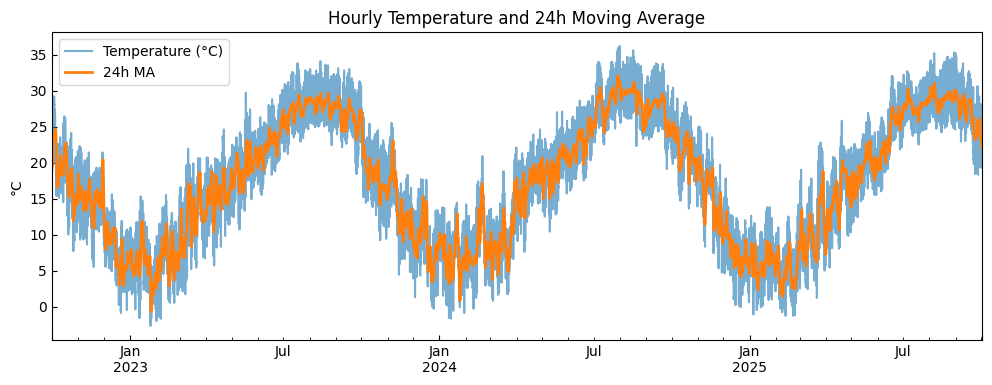

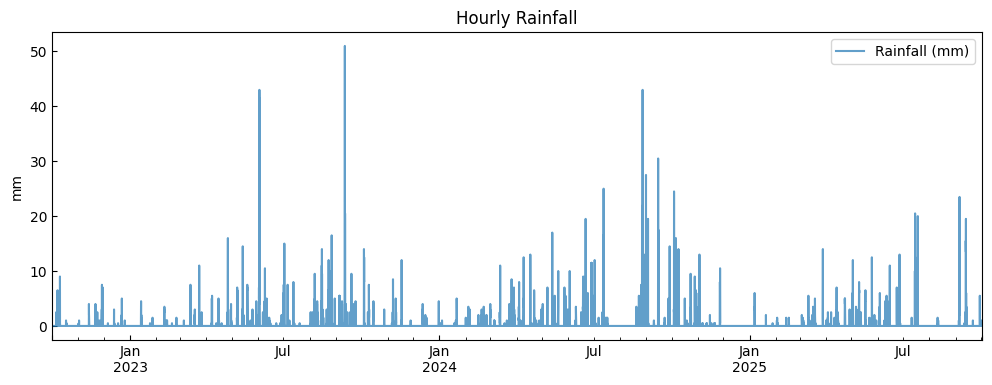

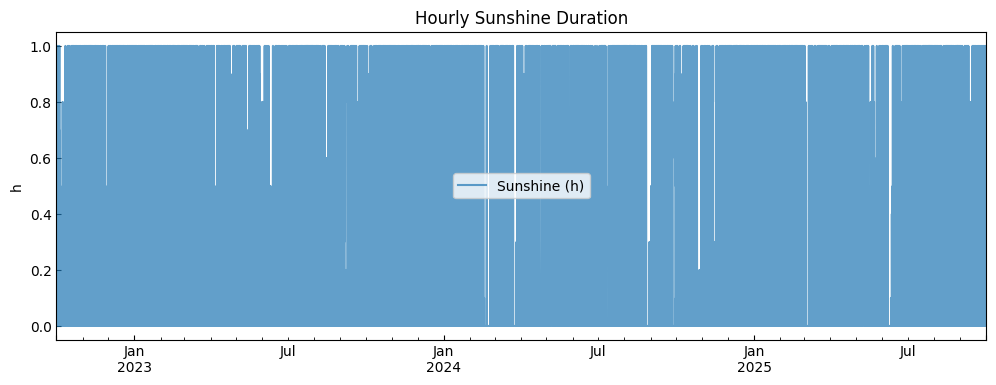

In [ ]:
# 24h移動平均
df["temp_ma24"] = df["temp_C"].rolling(window=24, min_periods=1).mean()

# グラフの目盛り（tick）の向きを内向きに描く設定です。技術原稿のグラフは目盛りは内向きです。
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.figure(figsize=(12, 4))
df["temp_C"].plot(label="Temperature (°C)", alpha=0.6)
df["temp_ma24"].plot(label="24h MA", linewidth=2)
plt.legend()
plt.title("Hourly Temperature and 24h Moving Average")
plt.xlabel("")
plt.ylabel("°C")
plt.show()

plt.figure(figsize=(12, 4))
df["precip_mm"].plot(label="Rainfall (mm)", alpha=0.7)
plt.legend()
plt.title("Hourly Rainfall")
plt.xlabel("")
plt.ylabel("mm")
plt.show()

plt.figure(figsize=(12, 4))
df["sunshine_h"].plot(label="Sunshine (h)", alpha=0.7)
plt.legend()
plt.title("Hourly Sunshine Duration")
plt.xlabel("")
plt.ylabel("h")
plt.show()


## 3) 相関の確認

- 相関係数（Pearson）で、3変数の関係性の強さと符号をざっくり把握します。

corr = df[["temp_C", "precip_mm", "sunshine_h"]].corr() は、
指定した3列（気温・降水量・日照時間）の相関係数行列を計算して corr（DataFrame）に入れます。

既定では Pearson（ピアソン）相関です。2変数 X,Y の相関係数r は  

$$r = \frac{cov(𝑋,𝑌)}{𝜎𝑋𝜎𝑌},$$
$$cov(X,Y) = \frac{1}{n-1}\sum_{i=1}^{n}(x_i - \bar{X})(y_i - \bar{Y}),$$
$$\sigma X = \sqrt{\frac{1}{n-1}\sum_{i=1}^{n}(x_i - \bar{X})^2},\qquad
\sigma Y = \sqrt{\frac{1}{n-1}\sum_{i=1}^{n}(y_i - \bar{Y})^2}$$

（共分散を標準偏差で正規化）


              temp_C  precip_mm  sunshine_h
temp_C      1.000000   0.047084    0.195930
precip_mm   0.047084   1.000000   -0.098912
sunshine_h  0.195930  -0.098912    1.000000


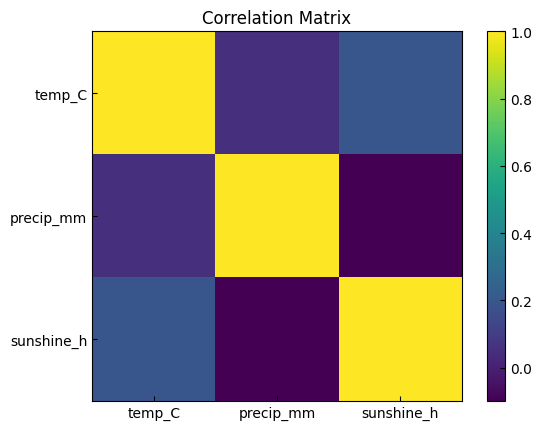

In [ ]:
corr = df[["temp_C", "precip_mm", "sunshine_h"]].corr()
print(corr)

# 簡易ヒートマップ
import numpy as np
plt.figure()
plt.imshow(corr, interpolation="nearest")
plt.xticks(range(3), ["temp_C","precip_mm","sunshine_h"])
plt.yticks(range(3), ["temp_C","precip_mm","sunshine_h"])
plt.colorbar()
plt.title("Correlation Matrix")
plt.show()


## 4) 回帰分析（単回帰）

- まずは **降水量のみ**、**日照時間のみ** で気温を説明してみます。(別の言い方をすると、降水量のみから気温の予測ができそうかを検討してみるということです。)

- モデルは最小二乗法（Ordinary Least Squares: OLS）を使います。


In [ ]:
# 降水量のみ
X_rain = sm.add_constant(df[["precip_mm"]])
y = df["temp_C"]
model_rain = sm.OLS(y, X_rain, missing="drop").fit()
#model_season = sm.OLS(df["temp_C"], X_season, missing="drop").fit()
print(model_rain.summary())

# 日照時間のみ
X_sun = sm.add_constant(df[["sunshine_h"]])
model_sun = sm.OLS(y, X_sun, missing="drop").fit()
print(model_sun.summary())


                            OLS Regression Results                            
Dep. Variable:                 temp_C   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     58.49
Date:                Thu, 30 Oct 2025   Prob (F-statistic):           2.11e-14
Time:                        04:24:42   Log-Likelihood:                -94006.
No. Observations:               26328   AIC:                         1.880e+05
Df Residuals:                   26326   BIC:                         1.880e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.2900      0.054    322.618      0.0

結果について、

決定係数（R-squared） R² = 0.002　→ 「このモデルが気温の変動を『降水量だけで』説明できている割合は0.2%」。つまり、ほぼ説明できていない（＝降水量単体では気温の予測力がほぼない）ということです。上の表で、const  17.2900 は y切片であり、降水量=0mmのときの平均的な気温を表します。

# **TODO-1**
上記の結果の表について単語を調べたりして内容を読み解き、(1) 降水量から気温を予測する回帰式、(2) 日照時間から気温を予測する回帰式、をそれぞれ書け。

※ヒント 6）でより複雑なモデルを数式で表しています。

## 5) 回帰分析（重回帰：降水＋日照）

- 2つの説明変数から、目的変数を予測します。


In [ ]:
X_multi = sm.add_constant(df[["precip_mm", "sunshine_h"]])
model_multi = sm.OLS(df["temp_C"], X_multi, missing="drop").fit()
print(model_multi.summary())


                            OLS Regression Results                            
Dep. Variable:                 temp_C   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     589.3
Date:                Thu, 30 Oct 2025   Prob (F-statistic):          4.49e-251
Time:                        04:24:43   Log-Likelihood:                -93459.
No. Observations:               26328   AIC:                         1.869e+05
Df Residuals:                   26325   BIC:                         1.869e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.1104      0.063    254.711      0.0

# **TODO-2**
上記の結果の表を読み解き、(3) 降水量と日照時間から気温を予測する回帰式を書け。

※ヒント 6）でより複雑なモデルを数式で表しています。

ここでも、決定係数（R-squared） R² = 0.043　で、降水量と日照時間だけでは気温が説明できないことが確認されました。

## 6) 季節・トレンドを加えた拡張モデル

- 季節ダミー（冬を基準に春・夏・秋のダミーを導入）
- 緩やかな年次変化を表現するためのトレンド項 `t`

気温の時間的変化を「短期的な要因（日照・降水）」＋「長期的傾向（トレンド）」＋「季節性（春夏秋冬）」で説明する多変量線形モデルを作ってみましょう。

🔹 数式（モデルの形）
$$ T_t = \beta_0 + \beta_1 P_t + \beta_2 S_t + \beta_3 t + \beta_4 D_{spring,t} + \beta_5 D_{summer,t} + \beta6_{atumn,t}+ \epsilon_t $$

$T_t$: 時刻tの気温（目的変数）、$P_t$: 降水量（mm）、$S_t$: 日照時間（h）、$t$: 長期トレンド。年単位の温暖化傾向など（β₃ > 0 なら上昇傾向）、$D_{spring,t}, D_{summer,t}, D_{automn,t}$: 春・夏・秋に1、冬は基準（冬ダミーは除く）、$\beta_{i}$: 各説明変数の効果の大きさ（線形寄与）、$\epsilon_{t}$: 残差（モデルで説明できない変動（風・突発的気象など））



In [ ]:
df = df.copy()
df["t"] = np.arange(len(df))

X_season = df[["precip_mm", "sunshine_h", "t",
               "season_spring", "season_summer", "season_autumn"]]
X_season = sm.add_constant(X_season)
model_season = sm.OLS(df["temp_C"], X_season, missing="drop").fit()
print(model_season.summary())


                            OLS Regression Results                            
Dep. Variable:                 temp_C   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                 1.212e+04
Date:                Thu, 30 Oct 2025   Prob (F-statistic):               0.00
Time:                        04:24:43   Log-Likelihood:                -76592.
No. Observations:               26328   AIC:                         1.532e+05
Df Residuals:                   26321   BIC:                         1.533e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.8969      0.071     68.632

決定係数（R-squared） R² = 0.734　とそこそこいい値がでました。「短期的な要因（日照・降水）」＋「長期的傾向（トレンド）」＋「季節性（春夏秋冬）」で、あるい程度気温を説明できるということです。ただし、係数を見てみると季節ダミーの係数が大きく、結局は、季節の平均気温をもとにモデルが作られているようなものだと解釈できます。

では、最後に実測値と予測値をグラフで比較してみましょう。

## 7) 予測と可視化

- 週平均へリサンプリングして、実測と予測の推移を比較します。


<Figure size 640x480 with 0 Axes>

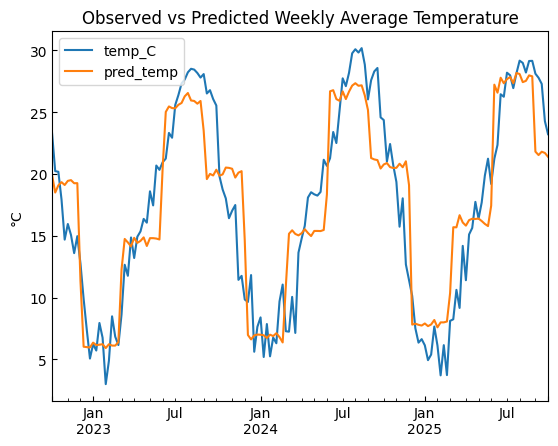

<Figure size 640x480 with 0 Axes>

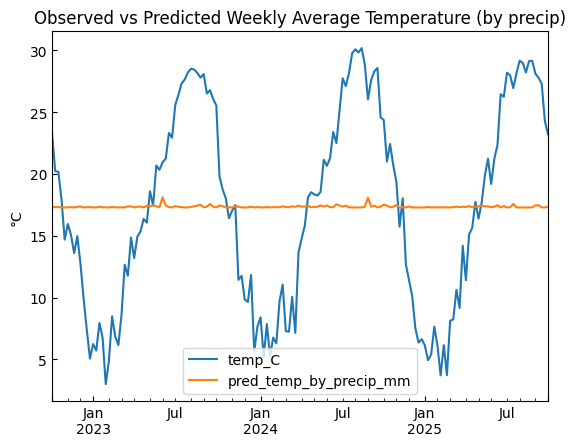

In [ ]:
df["pred_temp"] = model_season.predict(X_season)

weekly = df[["temp_C", "pred_temp"]].resample("W").mean()
plt.figure()
weekly.plot()
plt.title("Observed vs Predicted Weekly Average Temperature")
plt.xlabel("")
plt.ylabel("°C")
plt.show()


# せっかくなので降水量のみから気温を推定する場合を描画してみる
df = df.copy()
X_rain = df[["precip_mm"]]
X_rain = sm.add_constant(X_rain)

df["pred_temp_by_precip_mm"] = model_rain.predict(X_rain)

weekly = df[["temp_C", "pred_temp_by_precip_mm"]].resample("W").mean()

plt.figure()
weekly.plot()
plt.title("Observed vs Predicted Weekly Average Temperature (by precip)")
plt.xlabel("")
plt.ylabel("°C")
plt.show()

# # せっかくなので日射量のみから気温を推定する場合のグラフを描画してみる
# df = df.copy()
# X_sunshine_h = df[["sunshine_h"]]
# X_sunshine_h = sm.add_constant(X_sunshine_h)

# df["pred_temp_by_sunshine_h"] = model_sun.predict(X_sunshine_h)

# weekly = df[["temp_C", "pred_temp_by_sunshine_h"]].resample("W").mean()

# axes[1].plot(weekly)
# axes[1].set_title("Observed vs Predicted Weekly Average Temperature (by sunshine)")

# plt.figure()
# weekly.plot()
# plt.title("Observed vs Predicted Weekly Average Temperature (by sunshine)")
# plt.xlabel("")
# plt.ylabel("°C")
# plt.show()


## 8) 自己相関関数（ACF: Autocorrelation Function）

- ACF：ある時刻と「k時間後」の相関

# **TODO-3**
自己相関関数の定義を説明してください（パラメータを示して、定義式を記載してください。）。


2023-06-01 00:00:00 〜 2025-08-31 23:00:00 (19752, 3)


/tmp/ipython-input-745728255.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  summer = summer.asfreq("H")


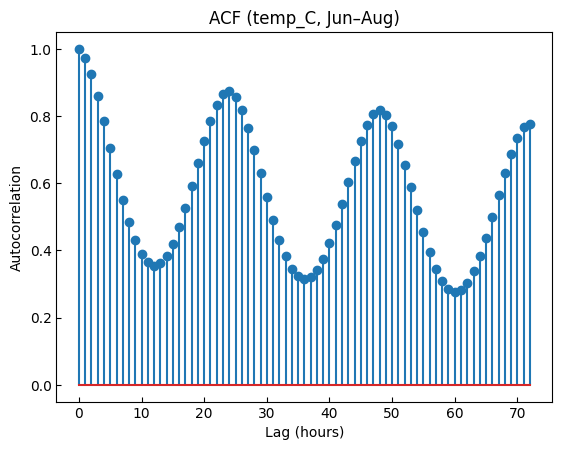

In [ ]:
# 読み込み
df = pd.read_csv("toyohashi_weather_hourly_imputed.csv", parse_dates=["Datetime"], index_col="Datetime")

# 6–8月だけ抽出（年度をまたいでもOK）
summer = df[df.index.month.isin([6,7,8])].copy()

# 必要列だけ
summer = summer[["temp_C", "precip_mm", "sunshine_h"]]

# （任意）時間粒度を整える：1時間
summer = summer.asfreq("H")

print(summer.index.min(), "〜", summer.index.max(), summer.shape)
summer.head()

# 自己相関のライブラリをインポート
from statsmodels.tsa.stattools import acf

# 例：気温（hourly）の ACF を 72時間ラグまで
y = summer["temp_C"].dropna()

nlags = 72
acf_vals = acf(y, nlags=nlags, fft=True)

plt.figure()
plt.stem(range(len(acf_vals)), acf_vals)
plt.title("ACF (temp_C, Jun–Aug)")
plt.xlabel("Lag (hours)")
plt.ylabel("Autocorrelation")
plt.show()


## **TODO-4**
winter = df[df.index.month.isin([12,1,2])].copy()
のデータを抜き出し、自己相関関数を求めグラフにプロットしなさい。グラフは画像として、ex4_B123456 に張り付けてください

In [ ]:
# dfは事前に読み込まれているとする
winter = df[df.index.month.isin([12, 1, 2])].copy()
winter = winter[["temp_C"]] # 気温データのみに絞る
winter = winter.asfreq("H") # 1時間間隔に整える（必要に応じて）
winter = winter.dropna() # 欠損値を除去

/tmp/ipython-input-1961180351.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  winter = winter.asfreq("H") # 1時間間隔に整える（必要に応じて）


In [ ]:
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt

y_winter = winter["temp_C"]
nlags = 72 # 例えば72時間（3日分）のラグまで計算
acf_vals_winter = acf(y_winter, nlags=nlags, fft=True)

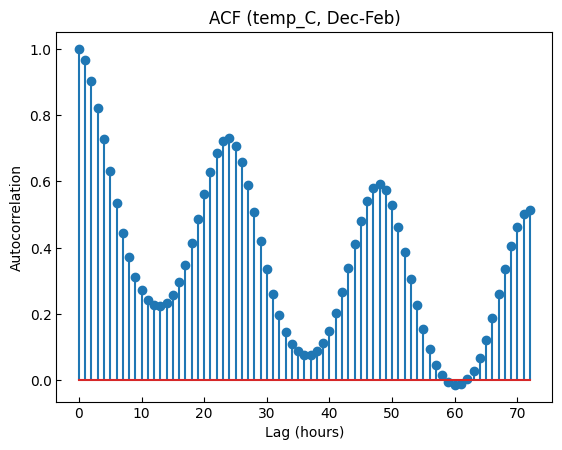

In [ ]:
plt.figure()
plt.stem(range(len(acf_vals_winter)), acf_vals_winter)
plt.title("ACF (temp_C, Dec-Feb)")
plt.xlabel("Lag (hours)")
plt.ylabel("Autocorrelation")
plt.show()

## 9) 演習課題（提出用）

 - TODO-1
上記の結果の表について単語を調べたりして内容を読み解き、
   - (1) 降水量から気温を予測する回帰式、
   - (2) 日照時間から気温を予測する回帰式、をそれぞれ書け。

 - TODO-2
上記の結果の表を読み解き、
   - (3) 降水量と日照時間から気温を予測する回帰式を書け。

 - TODO-3 自己相関関の定義を説明してください。

 - TODO-4 冬 winter = df[df.index.month.isin([12,1,2])].copy() のデータを抜き出し、自己相関関数を求めグラフにプロットしなさい。グラフは画像として、ex4_B123456 に張り付けてください。

 - TODO-5 降水・日照は気温に対し、それぞれ逆符号／正符号のどちらで影響するかを、その根拠を示しながら述べよ


## 10) まとめ
- 時系列データの可視化方法、データの相関の調べ方を確認した。
- 回帰分析、重回帰分析の方法を実装した。また、重回帰分析で出力したモデルを使ってデータの予測を行った。
- 自己相関関数を実装した。

データ出典：
本資料で使用した気温・降水量・日照時間データは、気象庁「過去の気象データ検索」（アメダス観測所：豊橋）のデータを基に作成した。
（気象庁ホームページ：https://www.data.jma.go.jp/obd/stats/etrn/
）